In [1]:
import pandas as pd
import numpy as np
import sklearn
from IPython.display import display, HTML, SVG, Image, display_html
pd.set_option('display.max_colwidth', 500)
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML('''<style>
    .widget-label { min-width: 20ex !important; }
</style>'''))
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('Emails.csv', index_col='Id')
df = df.fillna("")
df.head(10)

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545/C05739545.pdf,F-2015-04841,HRC_Email_296,...,,"Sullivan, Jacob J <Sullivan11@state.gov>",,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,,"UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739545\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN FULL\nFrom: Sullivan, Jacob J <Sullivan11@state.gov>\nSent: Wednesday, September 12, 2012 10:16 AM\nTo:\nSubject: FW: Wow\nFrom: Brose, Christian (Armed Services) (mailto:Christian_Brose@armed-servic,essenate.govi\nSent: Wednesday, September 12, 2012 10..."
2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE... SID,H,,,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546/C05739546.pdf,F-2015-04841,HRC_Email_296,...,,,,,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary","UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739546\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN\nPART B6\nFrom:\nSent:\nTo:\nSubject:\nAttachments:\nB6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nCONFIDENTIAL\nMarch 3, 201..."
3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547/C05739547.pdf,F-2015-04841,HRC_Email_296,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,"UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739547\nDate: 05/14/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN\nPART B6\nFrom: Mills, Cheryl D <MillsCD@state.gov>\nSent: Wednesday, September 12, 2012 11:52 AM\nTo: B6\nCc: Abedin, Huma\nSubject: Re: Chris Stevens\nThx\nOriginal Message\nFrom: Anne-Marie Slaughter [\nSent: Wednesday, September 12, 2012 07:46 AM\nT..."
4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550/C05739550.pdf,F-2015-04841,HRC_Email_296,...,,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,,"UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739550\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN PART\nB5\nFrom: Mills, Cheryl D <MillsCD@state.gov>\nSent: Wednesday, September 12,2012 12:44 PM\nTo:\nSubject: FVV: Cairo Condemnation - Final\nFrom: Smith, Dana S (PA)\nSent: Wednesday, September 12, 2012 11:53 AM\nTo Mills, Cheryl D\nSubject FW: Cair..."
5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE... SID,"Abedin, Huma",H,80,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+0

В таблице Emails.csv уже есть информация об отправителях и получателях, так что будем использовать только её. Ясно, что не нужно завязываться на разные даты и времена, поэтому интересная нам информация - это отправители/получатели и собственно текст письма. Однако, каждая строка таблицы - это целая цепочка писем, и видимо в том числе поэтому поле ExctractedBodyText определяется неправильно. Будем выделять текст писем из всей цепочки, не меняя метаданные. Так как вся цепочка относится обычно к одной теме, при кластеризации ее письма должны попасть в один кластер, так что не будем усложнять себе задачу.

In [3]:
not_interesting = ['from', 'to', 'sent', 'subject', 'attachments', 'case', 'doc', 'original', 'states', 'http', 'www', 'u.s. department', 'unclassified', 'doc no.', 'cc:', 'date', 'state', 'release', 'confidential', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
def throw_line(line):
    for val in not_interesting:
        if line.startswith(val):
            return True
    return False

def get_text(raw_text):
    res = ''
    line = ''
    for c in raw_text:
        if c == '\n':
            line = line.lower()
            if not throw_line(line):
                res += line + '\n'
            line = ''
        else:
            line += c
    
    if len(line) > 0 and not throw_line(line):
        res += line + '\n'
    return res

Достаём текст письма некоторой эвристикой: смотрим, с чего начинаются строки, которые не относятся к тексту письма, и выкидываем их из RawText. Понятно, что это неидеально, но результат получается адекватный.

In [4]:
extr_text = []
for row in df.itertuples():
    extr_text.append(get_text(row.RawText))
df['ExtractedText'] = extr_text
df.head(10)

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,...,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,ExtractedText
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545/C05739545.pdf,F-2015-04841,HRC_Email_296,...,"Sullivan, Jacob J <Sullivan11@state.gov>",,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,,"UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739545\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN FULL\nFrom: Sullivan, Jacob J <Sullivan11@state.gov>\nSent: Wednesday, September 12, 2012 10:16 AM\nTo:\nSubject: FW: Wow\nFrom: Brose, Christian (Armed Services) (mailto:Christian_Brose@armed-servic,essenate.govi\nSent: Wednesday, September 12, 2012 10...","what a wonderful, strong and moving statement by your boss. please tell her how much sen. mccain appreciated it. me\n \n"
2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE... SID,H,,,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546/C05739546.pdf,F-2015-04841,HRC_Email_296,...,,,,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary","UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739546\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN\nPART B6\nFrom:\nSent:\nTo:\nSubject:\nAttachments:\nB6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nCONFIDENTIAL\nMarch 3, 201...","part b6\nb6\nh: latest how syria is aiding qaddafi and more... sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nmarch 3, 2011\nfor: hillary\nre: syria aiding qaddafi\nthis memo has two parts. part one is the report that syria is providing air support for qaddafi. part two is a note\nseems that the situation is developing into a protracted civil war with various nations backing opposing sides\nwith unforeseen consequences. under these circumstances the cr..."
3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547/C05739547.pdf,F-2015-04841,HRC_Email_296,...,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,"UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739547\nDate: 05/14/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN\nPART B6\nFrom: Mills, Cheryl D <MillsCD@state.gov>\nSent: Wednesday, September 12, 2012 11:52 AM\nTo: B6\nCc: Abedin, Huma\nSubject: Re: Chris Stevens\nThx\nOriginal Message\nFrom: Anne-Marie Slaughter [\nSent: Wednesday, September 12, 2012 07:46 AM\nT...",part b6\nthx\nas our soldiers do. thinking of you and pat and everyone this morning.\nam\n \n
4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550/C05739550.pdf,F-2015-04841,HRC_Email_296,...,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, 

In [5]:
def get_str(cur_list):
    res = ''
    for item in cur_list:
        res += item + '\n'
    return res

data = []
for row in df.itertuples():
    data.append(get_str([row.MetadataFrom, row.MetadataTo, row.MetadataSubject, row.ExtractedText]))
df['data'] = data
df.head(10)

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,...,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,ExtractedText,data
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545/C05739545.pdf,F-2015-04841,HRC_Email_296,...,,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,,"UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739545\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN FULL\nFrom: Sullivan, Jacob J <Sullivan11@state.gov>\nSent: Wednesday, September 12, 2012 10:16 AM\nTo:\nSubject: FW: Wow\nFrom: Brose, Christian (Armed Services) (mailto:Christian_Brose@armed-servic,essenate.govi\nSent: Wednesday, September 12, 2012 10...","what a wonderful, strong and moving statement by your boss. please tell her how much sen. mccain appreciated it. me\n \n","Sullivan, Jacob J\nH\nWOW\nwhat a wonderful, strong and moving statement by your boss. please tell her how much sen. mccain appreciated it. me\n \n\n"
2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE... SID,H,,,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546/C05739546.pdf,F-2015-04841,HRC_Email_296,...,,,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary","UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739546\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN\nPART B6\nFrom:\nSent:\nTo:\nSubject:\nAttachments:\nB6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nCONFIDENTIAL\nMarch 3, 201...","part b6\nb6\nh: latest how syria is aiding qaddafi and more... sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nmarch 3, 2011\nfor: hillary\nre: syria aiding qaddafi\nthis memo has two parts. part one is the report that syria is providing air support for qaddafi. part two is a note\nseems that the situation is developing into a protracted civil war with various nations backing opposing sides\nwith unforeseen consequences. under these circumstances the cr...","\nH\nH: LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE... SID\npart b6\nb6\nh: latest how syria is aiding qaddafi and more... sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nmarch 3, 2011\nfor: hillary\nre: syria aiding qaddafi\nthis memo has two parts. part one is the report that syria is providing air support for qaddafi. part two is a note\nseems that the situation is developing into a protracted civil war with various nations backing opposing sides\nw..."
3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547/C05739547.pdf,F-2015-04841,HRC_Email_296,...,"Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,"UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739547\nDate: 05/14/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN\nPART B6\nFrom: Mills, Cheryl D <MillsCD@state.gov>\nSent: Wednesd

Конкатенируем нужные признаки

In [6]:
data = np.asarray(data)
print(len(data))

7945


In [7]:
def fill_features(data, pattern=None, range_lens=(1, 1), ignore_words=None, need_print=False):
    if pattern is None:
        vectorizer = TfidfVectorizer(ngram_range=range_lens, stop_words=ignore_words)
    else:
        vectorizer = TfidfVectorizer(token_pattern=pattern, ngram_range=range_lens, stop_words=ignore_words)
    features = vectorizer.fit_transform(data)
    names = vectorizer.get_feature_names()
    occurrences = np.asarray(features.sum(axis=0)).ravel()
    to_sort = pd.DataFrame()
    to_sort['name'] = names
    to_sort['occurrence'] = occurrences
    to_sort = to_sort.sort_values(by='occurrence', ascending=False)
    if need_print:
        print(to_sort[:10])
    return vectorizer, features

In [8]:
fill_features(data, range_lens=(2, 2), need_print=True)

                 name  occurrence
335523         of the  123.557208
440694      state gov  117.451503
21316     abedin huma  101.569335
240589         in the   96.977519
335265       of state   74.907262
487007         to the   71.218705
341430         on the   65.930626
301402   mills cheryl   63.519627
142857  department of   63.466297
151961         doc no   60.178927


(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(2, 2), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None),
 <7945x538768 sparse matrix of type '<class 'numpy.float64'>'
 	with 1883669 stored elements in Compressed Sparse Row format>)

In [9]:
from nltk.corpus import stopwords
ignore = stopwords.words('english')
for item in not_interesting:
    ignore.append(item)
print(ignore[-10:])
vectorizer, features = fill_features(data, range_lens=(2, 2), ignore_words=ignore, pattern=r'([A-Za-z][A-Za-z][A-Za-z]+)', need_print=True)

['state', 'release', 'confidential', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
                         name  occurrence
505               abedin huma  124.601351
300809           mills cheryl   81.486299
465700         sullivan jacob   67.860361
549               abedinh gov   58.639322
465763         sullivanjj gov   44.706570
300947            millscd gov   42.386978
269778               let know   40.287932
125000  department department   36.687769
250157          jiloty lauren   36.459710
250163           jilotylc gov   31.624301


Проигнорируем стандартные english stopwords, а также выписанные ранее "неинтересные" слова

In [10]:
import re
pattern = re.compile('[A-Za-z0-9]+')
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words("".join(data))
finder.apply_freq_filter(2)
ignored_words = nltk.corpus.stopwords.words('english')
finder.apply_word_filter(lambda w: w.lower() in ignored_words or not pattern.match(w))
finder.nbest(bigram_measures.pmi, 10)

[('Q', 'U'),
 ('Z', 'Z'),
 ('X', 'P'),
 ('E', 'X'),
 ('N', 'G'),
 ('X', 'X'),
 ('U', 'P'),
 ('V', 'E'),
 ('C', 'K'),
 ('L', 'L')]

Почему-то пример с http://www.nltk.org/howto/collocations.html находит не биграммы, а пары символов

In [11]:
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.cluster import KMeans

vectorizer, features = fill_features(data, range_lens=(2, 2), ignore_words=ignore, pattern=r'([A-Za-z][A-Za-z][A-Za-z]+)', need_print=False) 
num_clusters = 15
model = KMeans(n_clusters=num_clusters, n_jobs=-1)
#model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
model.fit(features)
preds = model.predict(features)

In [12]:
answers = [[] for i in range(num_clusters)]
cnt = 0
for row in df.itertuples():
    answers[preds[cnt]].append([row.MetadataSubject, row.MetadataFrom, row.MetadataTo])
    cnt += 1
print('cluster_id', 'number of mails')
for i in range(num_clusters):
    print(i, len(answers[i]))

cluster_id number of mails
0 20
1 99
2 75
3 20
4 225
5 231
6 279
7 131
8 236
9 4846
10 102
11 33
12 1034
13 53
14 561


In [13]:
import random
for i in range(num_clusters):
    print('cluster ', i)
    cur_len = len(answers[i])
    for num in range(5):
        cur_id = random.randint(0, cur_len - 1)
        print(answers[i][cur_id])

cluster  0
['INTERVENTION', 'Rooney, Megan', 'H']
["PM BELLERIVE ON DONORS' CONFERENCE, SOFA, ADOPTIONS, MIGRANTS, POLITICAL DILEMA AND MORE", 'Mills, Cheryl D', 'H']
['AIPAC SPEECH', 'Sullivan, Jacob J', 'H']
['AIPAC SPEECH', 'Sullivan, Jacob J', 'H']
['SPEECH', 'Rooney, Megan', 'H']
cluster  1
['MINI SCHEDULE 9/3/10 FRIDAY', 'Jiloty, Lauren C', 'H']
['MINI SCHEDULE 10/21/09 WEDNESDAY', 'Jiloty, Lauren C', 'H']
['MINI SCHEDULE FRIDAY 5/5/09', 'Jiloty, Lauren C', 'H']
['MINI SCHEDULE 8/16/10 MONDAY', 'Jiloty, Lauren C', 'H']
['REVISED MINI SCHEDULE 6/5/09', 'Jiloty, Lauren C', 'H']
cluster  2
['QUESTION AND UPDATE', 'H', 'hanleymr@state.gov']
['HOLDER', 'Hanley, Monica R', 'H']
['CALLS', 'H', 'abedinh@state.gov']
['HONDURAS MILITARY COUP DECISION', 'H', 'millscd@state.gov']
['RE:', 'Abedin, Huma', 'H']
cluster  3
['TURKEY-ARMENIA TEXT FOR DAVUTOGLU CALL', 'Abedin, Huma', 'H']
['TURKEY-ARMENIA TEXT FOR DAVUTOGLU CALL', 'Abedin, Huma', 'H']
['TURKEY-ARMENIA TEXT FOR DAVUTOGLU CALL', 'H',

Количество кластеров выбиралось на глаз, чтобы во всех кластерах было не совсем маленькое количество писем, и в то же время было несколько больших кластеров. Для каждого кластера выведены 5 случайных писем. Видно, что в одном кластере часто бывают одинаковые отправители/получатели и происходит группировка по темам писем - например, Турция-Армения в 3 кластере, Гвинея в 11-м.  В 13-м кластере черновики писем и сообщения из СМИ, в 1 кластере сообщения, связанные с распорядком дня, в 0-м кластере сообщения о выступлениях.

[(0, 0, 0, 1), (1.0, 0.41691218161806393, 0.0, 1.0), (1.0, 0.83382436323612785, 0.0, 1.0), (0.74926345514580817, 1.0, 0.0, 1.0), (0.30918948566007398, 1.0, 0.0, 1.0), (0.0, 1.0, 0.10772241105651532, 1.0), (0.0, 1.0, 0.52463196614175589, 1.0), (0.0, 1.0, 0.96470316317617644, 1.0), (0.0, 0.61838487757605409, 1.0, 1.0), (0.0, 0.201472695957991, 1.0, 1.0), (0.21543948566007359, 0.0, 1.0, 1.0), (0.65551345514580817, 0.0, 1.0, 1.0), (1.0, 0.0, 0.92757436323612774, 1.0), (1.0, 0.0, 0.51066218161806387, 1.0), (1.0, 0.0, 0.09375, 1.0)]


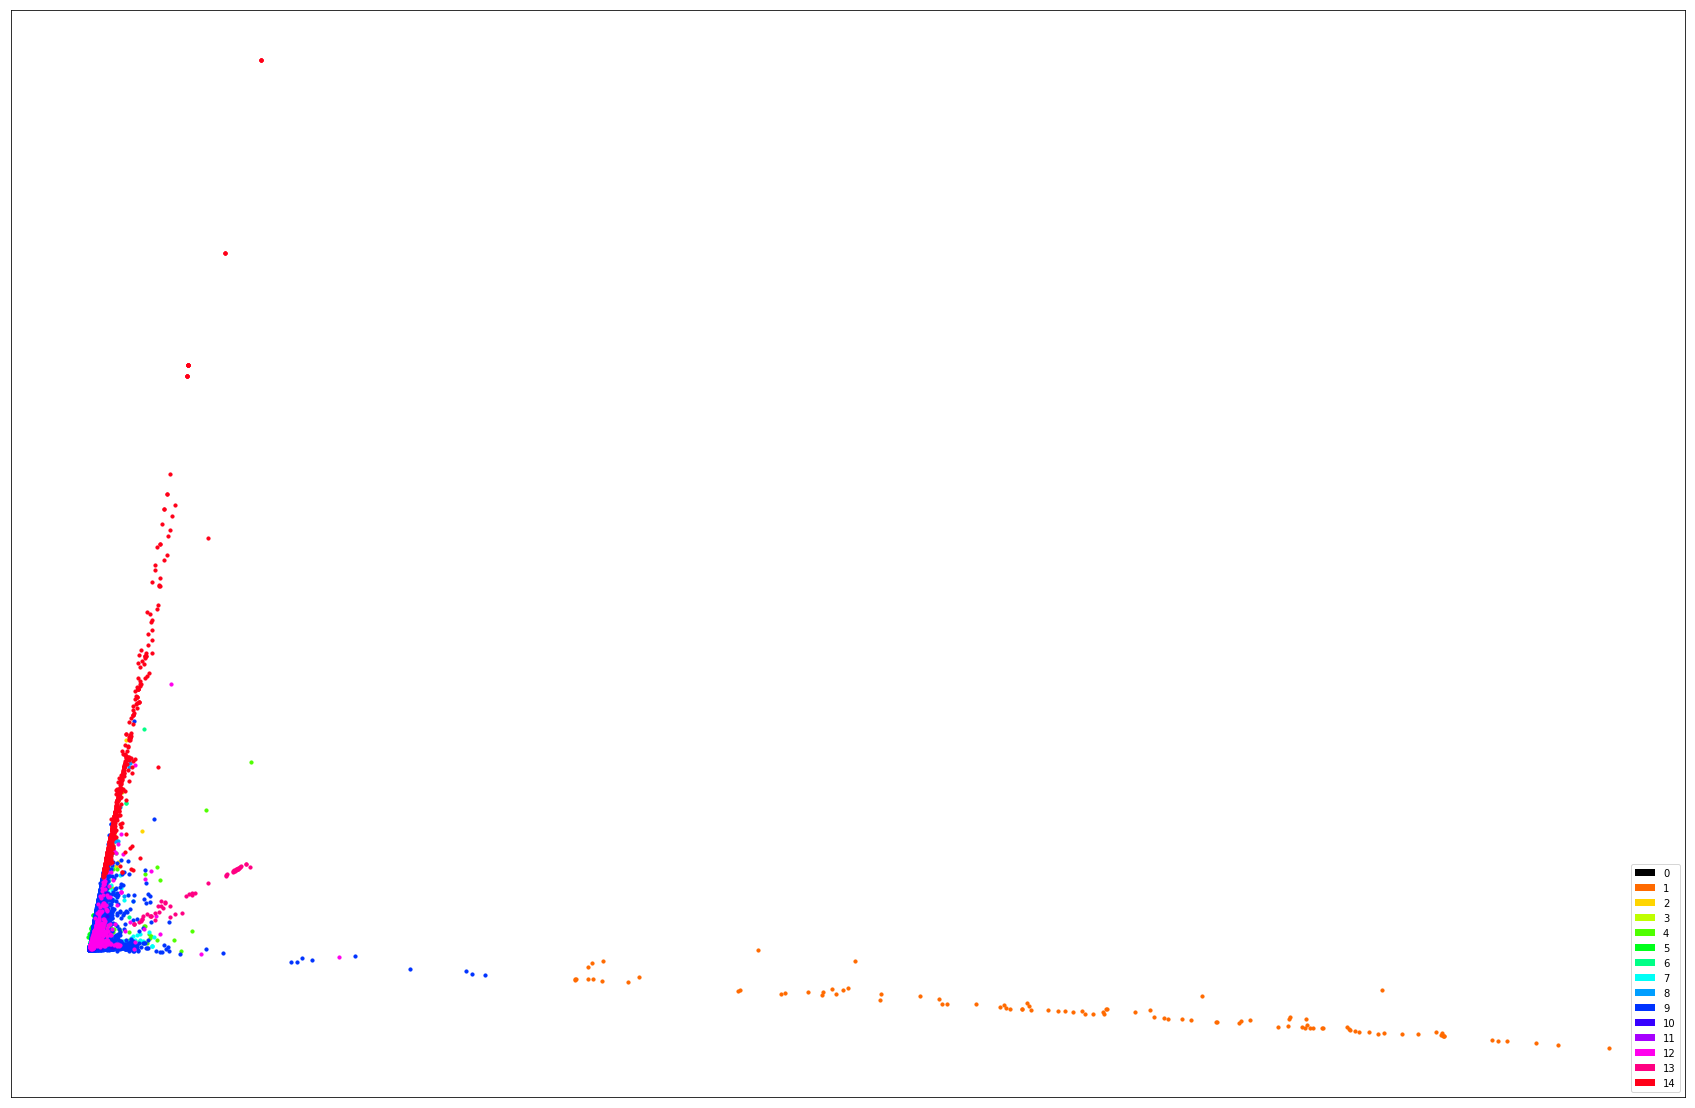

In [36]:
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import decomposition
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.colors as cols

def get_cmap(N):
    '''Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.'''
    color_norm  = cols.Normalize(vmin=0, vmax=N-1)
    scalar_map = cm.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

colors = [get_cmap(num_clusters)(i) for i in range(num_clusters)]
colors[0] = (0, 0, 0, 1)
print(colors)

features_compressed = decomposition.TruncatedSVD(n_components=2).fit_transform(features)
plt.clf()
def draw(data):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    plt.figure(figsize=(30,20))
    ax = plt.subplot(111)
    points_x = [[] for i in range(num_clusters)]
    points_y = [[] for i in range(num_clusters)]
    #colors = cm.rainbow(np.linspace(0, 1, num_clusters))
    for i in range(data.shape[0]):
        points_x[preds[i]].append(data[i, 0])
        points_y[preds[i]].append([data[i, 1]])
    for x, y, c in zip(points_x, points_y, colors):
        ax.scatter(x, y, 10, c)
    classes = range(num_clusters)
    recs = []
    for i in range(0, len(colors)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i]))
    plt.legend(recs,classes,loc=4)
    plt.xticks([]), plt.yticks([])
        
draw(features_compressed)
plt.show()

Выбрана самая очевидная визуализация - метод главных компонент с количеством компонент, равным 2. Цвета точек немного подогнаны, чтобы было видно кластеры.